In [23]:
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import os
import pandas as pd

In [24]:
# adapted from https://github.com/embeddings-benchmark/mteb/blob/main/mteb/evaluation/evaluators/PairClassificationEvaluator.py
import numpy as np
from sklearn.metrics import average_precision_score
from collections import defaultdict

    

def _compute_metrics(
    scores: np.ndarray, labels: np.ndarray, high_score_more_similar: bool
) -> dict[str, float]:
    """Compute the metrics for the given scores and labels.

    Args:
        scores: The similarity/dissimilarity scores for the pairs, specified as an array of shape (n_pairs, ).
        labels: The labels for the pairs, specified as an array of shape (n_pairs, ).
        high_score_more_similar: If true, then the higher the score, the more similar the pairs are.

    Returns:
        The metrics for the given scores and labels.
    """
    acc, acc_threshold = find_best_acc_and_threshold(
        scores, labels, high_score_more_similar
    )
    (
        f1,
        precision,
        recall,
        f1_threshold,
    ) = find_best_f1_and_threshold(
        scores, labels, high_score_more_similar
    )
    ap = ap_score(
        scores, labels, high_score_more_similar
    )

    return {
        "accuracy": float(acc),
        "accuracy_threshold": float(acc_threshold),
        "f1": float(f1),
        "f1_threshold": float(f1_threshold),
        "precision": float(precision),
        "recall": float(recall),
        "ap": float(ap),
    }

def find_best_acc_and_threshold(scores, labels, high_score_more_similar: bool):
    assert len(scores) == len(labels)
    rows = list(zip(scores, labels))

    rows = sorted(rows, key=lambda x: x[0], reverse=high_score_more_similar)

    max_acc = 0
    best_threshold = -1

    positive_so_far = 0
    remaining_negatives = sum(np.array(labels) == 0)

    for i in range(len(rows) - 1):
        score, label = rows[i]
        if label == 1:
            positive_so_far += 1
        else:
            remaining_negatives -= 1

        acc = (positive_so_far + remaining_negatives) / len(labels)
        if acc > max_acc:
            max_acc = acc
            best_threshold = (rows[i][0] + rows[i + 1][0]) / 2

    return max_acc, best_threshold

def find_best_f1_and_threshold(scores, labels, high_score_more_similar: bool):
    assert len(scores) == len(labels)

    scores = np.asarray(scores)
    labels = np.asarray(labels)

    rows = list(zip(scores, labels))

    rows = sorted(rows, key=lambda x: x[0], reverse=high_score_more_similar)

    best_f1 = best_precision = best_recall = 0
    threshold = 0
    nextract = 0
    ncorrect = 0
    total_num_duplicates = sum(labels)

    for i in range(len(rows) - 1):
        score, label = rows[i]
        nextract += 1

        if label == 1:
            ncorrect += 1

        if ncorrect > 0:
            precision = ncorrect / nextract
            recall = ncorrect / total_num_duplicates
            f1 = 2 * precision * recall / (precision + recall)
            if f1 > best_f1:
                best_f1 = f1
                best_precision = precision
                best_recall = recall
                threshold = (rows[i][0] + rows[i + 1][0]) / 2

    return best_f1, best_precision, best_recall, threshold

def ap_score(scores, labels, high_score_more_similar: bool):
    return average_precision_score(
        labels, scores * (1 if high_score_more_similar else -1)
    )
def compute_metrics(cosine_scores,labels):
    cosine_scores = cosine_scores
    similarity_scores = 1- cosine_scores  # Default to cosine similarity


    labels = np.asarray(labels)
    output_scores = {}
    max_scores = defaultdict(list)
    for short_name, name, scores, reverse in [
        ["similarity", "Model-Specified Similarity", similarity_scores, False],
    ]:
        metrics = _compute_metrics(scores, labels, reverse)
        for metric_name, metric_value in metrics.items():
            output_scores[f"{short_name}_{metric_name}"] = metric_value
            max_scores[metric_name].append(metric_value)

    return output_scores

In [25]:
folder_path = 'model_data'

# List all files in the folder
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
files

['.customtest_encoder_only_base_bge-large-en-v1.5.pickle',
 'BAAIbge-large-en-v1.5.pickle']

In [26]:
# load files

test_data_per_model = {}

for file_path in files:
    with open(f"{folder_path}/{file_path}","rb") as file:
        data = pickle.load(file)
        #test_data_per_model[data[0]["model"]] = data
        test_data_per_model[file_path] = data


In [27]:
test_data_per_model

{'.customtest_encoder_only_base_bge-large-en-v1.5.pickle': [{'model': './custom/test_encoder_only_base_bge-large-en-v1.5',
   'categories': ['cyber', 'krimisi', 'innotech'],
   'categories_embedding': [array([-0.26458916,  0.26631302,  0.37924272, ...,  0.0530602 ,
           -0.1357125 ,  0.33086962], shape=(1024,), dtype=float32),
    array([ 0.2942476 , -0.41891012, -0.19985126, ..., -0.06156898,
            0.32913944,  0.28274137], shape=(1024,), dtype=float32),
    array([ 0.2789928 ,  0.03453681,  0.0099855 , ..., -0.03326193,
           -0.15630962,  0.06050025], shape=(1024,), dtype=float32)],
   'url': 'https://de.euronews.com/2020/11/02/erster-lockdown-tag-polizei-kontrolliert-scharfer/',
   'content_embedding': array([-0.11823434,  0.07860155, -0.07471552, ..., -0.6110429 ,
          -0.42479107,  0.3580976 ], shape=(1024,), dtype=float32),
   'is_relevant': False},
  {'model': './custom/test_encoder_only_base_bge-large-en-v1.5',
   'categories': ['cyber', 'krimisi', 'innot

In [28]:
def calc_similarities(query,documents):
    question = query
    question = question.reshape(1, -1)
    answers = documents
    similarities = cosine_similarity(question,answers)
    return similarities

# Test content to category (break condition)

In [29]:
# Initialize an empty dictionary to store the data for DataFrame
similarity_data = {}

# Iterate over the test data per model
for model_name, model_test_data in test_data_per_model.items():  # Assuming test_data_per_model is a dictionary
    for document in model_test_data:
        #check if the document is relevant
        for category, similarity in [(document["categories"][i] if document["categories"] != None else ["cyber","krimisi","innotech"][i] , calc_similarities(x, [document["content_embedding"]])[0][0]) 
                                for i, x in enumerate(document["categories_embedding"])]:
        
            # Use document URL as the key in the dictionary, and store categories and similarities per model
            doc_url = document["url"]  # Assuming document has a "url" field
            if doc_url not in similarity_data:
                similarity_data[doc_url] = {
                    "Category": category,
                    "URL": doc_url,
                    "is_relevant": document["is_relevant"]
                }
            # Add the similarity score for the current model to the dictionary
            similarity_data[doc_url][model_name] = similarity

# Convert the similarity_data dictionary into a pandas DataFrame
similarity_df = pd.DataFrame.from_dict(similarity_data, orient='index')

# Display the DataFrame
is_relevant_df = similarity_df[similarity_df["is_relevant"] == True]
is_not_relevant_df = similarity_df[similarity_df["is_relevant"] == False]

"""
with pd.option_context('display.max_rows', None,):
    display(similarity_df)
"""


"\nwith pd.option_context('display.max_rows', None,):\n    display(similarity_df)\n"

In [30]:
similarity_df

,Category,URL,is_relevant,.customtest_encoder_only_base_bge-large-en-v1.5.pickle,BAAIbge-large-en-v1.5.pickle
https://de.euronews.com/2020/11/02/erster-lockdown-tag-polizei-kontrolliert-scharfer/,cyber,https://de.euronews.com/2020/11/02/erster-lock...,False,0.545283,0.451559
https://thehackernews.com/search/?q=%2410+%EB%AC%B4%EB%A3%8C+%EB%AC%B4%EB%B3%B4%EC%A6%9D+%EC%B9%B4%EC%A7%80%EB%85%B8+%EB%B3%B4%EB%84%88%EC%8A%A4-%EB%AC%B4%EB%A3%8C+%EB%AC%B4%EB%B3%B4%EC%A6%9D+%EC%B9%B4%EC%A7%80%EB%85%B8+%EC%8A%AC%EB%A1%AF%E3%80%90eggc.vip%E3%80%91u0B,cyber,https://thehackernews.com/search/?q=%2410+%EB%...,False,0.539610,0.495215
https://thehackernews.com/2023/05/alert-hackers-exploit-barracuda-email.html?_m=3n.009a.3057.na0ao44044.21eb,cyber,https://thehackernews.com/2023/05/alert-hacker...,False,0.500971,0.455033
https://de.euronews.com/2014/12/20/uno-generalsekretaer-besucht-ebolagebiete-in-westafrika/,cyber,https://de.euronews.com/2014/12/20/uno-general...,False,0.538324,0.446110
https://de.euronews.com/2015/07/17/hadi-treue-truppen-vertreiben-huthis-aus-aden/,cyber,https://de.euronews.com/2015/07/17/hadi-treue-...,False,0.539397,0.455868
https://de.euronews.com/2017/07/08/schlacht-um-mossul-auf-den-letzten-metern/,cyber,https://de.euronews.com/2017/07/08/schlacht-um...,False,0.552092,0.478449
https://de.euronews.com/wetter/suedamerika/brasilien/aracoiaba-da-serra/,cyber,https://de.euronews.com/wetter/suedamerika/bra...,False,0.518569,0.371507
https://de.euronews.com/tag/europa/?p=80,cyber,https://de.euronews.com/tag/europa/?p=80,False,0.555306,0.461194
https://de.euronews.com/wetter/asien/porzellan/weifang/,cyber,https://de.euronews.com/wetter/asien/porzellan...,False,0.540027,0.441980
https://thehackernews.com/search/?q=%EB%B0%94%EC%B9%B4%EB%9D%BC+%EC%82%AC%EC%9D%B4%ED%8A%B8+%EB%94%94%EC%8B%9C-%EC%B9%B4%EC%A7%80%EB%85%B8+119%E3%80%90eggc.vip%E3%80%9138Q,cyber,https://thehackernews.com/search/?q=%EB%B0%94%...,False,0.549639,0.496328


In [ ]:

# Calculate statistical values for each model
stats_custom = similarity_df['.customtest_encoder_only_base_bge-large-en-v1.5.pickle'].describe()
stats_baaibge = similarity_df['BAAIbge-large-en-v1.5.pickle'].describe()

# Display the statistical values
print("Statistics for .customtest_encoder_only_base_bge-large-en-v1.5.pickle:")
print(stats_custom)
print("\nStatistics for BAAIbge-large-en-v1.5.pickle:")
print(stats_baaibge)

# Calculate statistical values for relevant and non-relevant subsets
stats_relevant_custom = is_relevant_df['.customtest_encoder_only_base_bge-large-en-v1.5.pickle'].describe()
stats_relevant_baaibge = is_relevant_df['BAAIbge-large-en-v1.5.pickle'].describe()

stats_not_relevant_custom = is_not_relevant_df['.customtest_encoder_only_base_bge-large-en-v1.5.pickle'].describe()
stats_not_relevant_baaibge = is_not_relevant_df['BAAIbge-large-en-v1.5.pickle'].describe()

# Display the statistical values
print("Statistics for relevant documents (.customtest_encoder_only_base_bge-large-en-v1.5.pickle):")
print(stats_relevant_custom)
print("\nStatistics for relevant documents (BAAIbge-large-en-v1.5.pickle):")
print(stats_relevant_baaibge)

print("\nStatistics for non-relevant documents (.customtest_encoder_only_base_bge-large-en-v1.5.pickle):")
print(stats_not_relevant_custom)
print("\nStatistics for non-relevant documents (BAAIbge-large-en-v1.5.pickle):")
print(stats_not_relevant_baaibge)

Statistics for .customtest_encoder_only_base_bge-large-en-v1.5.pickle:
count    20.000000
mean      0.543588
std       0.026031
min       0.500971
25%       0.522814
50%       0.542590
75%       0.555935
max       0.586171
Name: .customtest_encoder_only_base_bge-large-en-v1.5.pickle, dtype: float64

Statistics for BAAIbge-large-en-v1.5.pickle:
count    20.000000
mean      0.467357
std       0.033256
min       0.371507
25%       0.450682
50%       0.461706
75%       0.495493
max       0.514879
Name: BAAIbge-large-en-v1.5.pickle, dtype: float64
Statistics for relevant documents (.customtest_encoder_only_base_bge-large-en-v1.5.pickle):
count    10.000000
mean      0.549254
std       0.032979
min       0.502577
25%       0.519461
50%       0.551487
75%       0.582197
max       0.586171
Name: .customtest_encoder_only_base_bge-large-en-v1.5.pickle, dtype: float64

Statistics for relevant documents (BAAIbge-large-en-v1.5.pickle):
count    10.000000
mean      0.479389
std       0.027834
min   

In [ ]:
from sklearn.metrics import roc_auc_score

# Extract the true labels and predicted scores for each model
true_labels = similarity_df['is_relevant'].astype(bool).astype(int)
scores_custom = similarity_df['.customtest_encoder_only_base_bge-large-en-v1.5.pickle']
scores_baaibge = similarity_df['BAAIbge-large-en-v1.5.pickle']

# Calculate the AUC-ROC scores
auc_roc_custom = roc_auc_score(true_labels, scores_custom)
auc_roc_baaibge = roc_auc_score(true_labels, scores_baaibge)



print()

print(f"AUC-ROC for BAAIbge-large-en-v1.5.pickle: {auc_roc_baaibge:.4f}")
print(f".customtest_encoder_only_base_bge-large-en-v1.5.pickle: {auc_roc_custom:.4f}")


AUC-ROC for BAAIbge-large-en-v1.5.pickle: 0.7100
.customtest_encoder_only_base_bge-large-en-v1.5.pickle: 0.6100


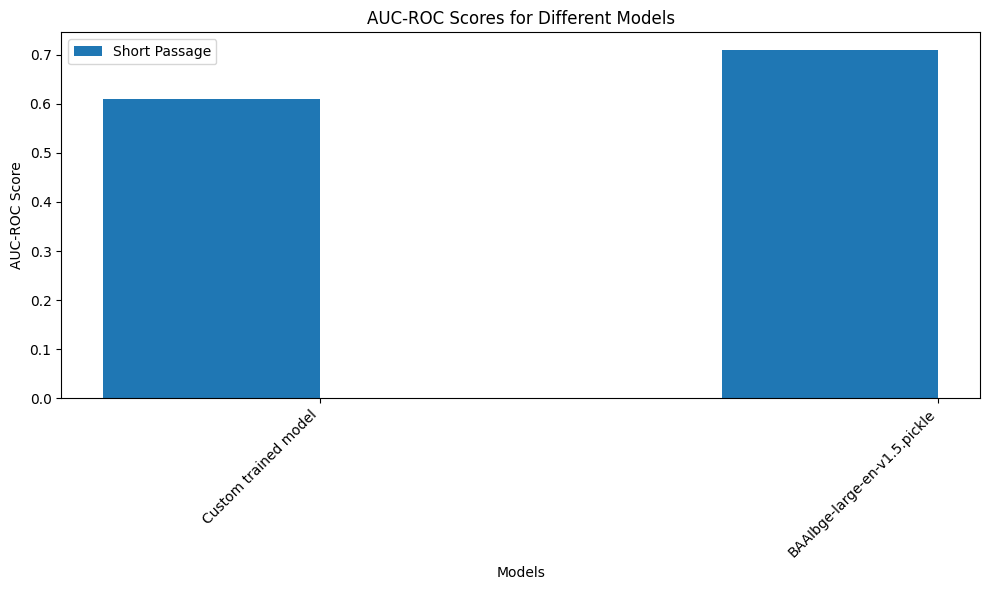

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

# Data for plotting
models = ['Custom trained model', 'BAAIbge-large-en-v1.5.pickle']
auc_roc_scores = [auc_roc_custom, auc_roc_baaibge]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the AUC-ROC scores
bar_width = 0.35
index = range(len(models))

bar1 = ax.bar(index, auc_roc_scores, bar_width, label='Short Passage')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('AUC-ROC Score')
ax.set_title('AUC-ROC Scores for Different Models')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Scale the y-axis
#ax.set_ylim(0.7, 0.85)

# Display the plot
plt.tight_layout()
plt.show()


In [34]:
print("BAAIbge")
display(compute_metrics(similarity_df['BAAIbge-large-en-v1.5.pickle'], similarity_df['is_relevant']))
print("Custom")
display(compute_metrics(similarity_df['.customtest_encoder_only_base_bge-large-en-v1.5.pickle'], similarity_df['is_relevant']))


BAAIbge


{'similarity_accuracy': 0.7,
 'similarity_accuracy_threshold': 0.4991515278816223,
 'similarity_f1': 0.7407407407407407,
 'similarity_f1_threshold': 0.5530012845993042,
 'similarity_precision': 0.5882352941176471,
 'similarity_recall': 1.0,
 'similarity_ap': 0.7713830532212884}

Custom


{'similarity_accuracy': 0.75,
 'similarity_accuracy_threshold': 0.4434357285499573,
 'similarity_f1': 0.6896551724137931,
 'similarity_f1_threshold': 0.49822553992271423,
 'similarity_precision': 0.5263157894736842,
 'similarity_recall': 1.0,
 'similarity_ap': 0.7563570691434467}